In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Experiment setting

In [2]:

dataset_name = "Breast"
m_perc = 10
mask = 1
data_file= "dataset/" + dataset_name + "/data.csv"
feat_types_file = "dataset/" + dataset_name + "/data_types.csv"
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### Data loading and Feature analysis

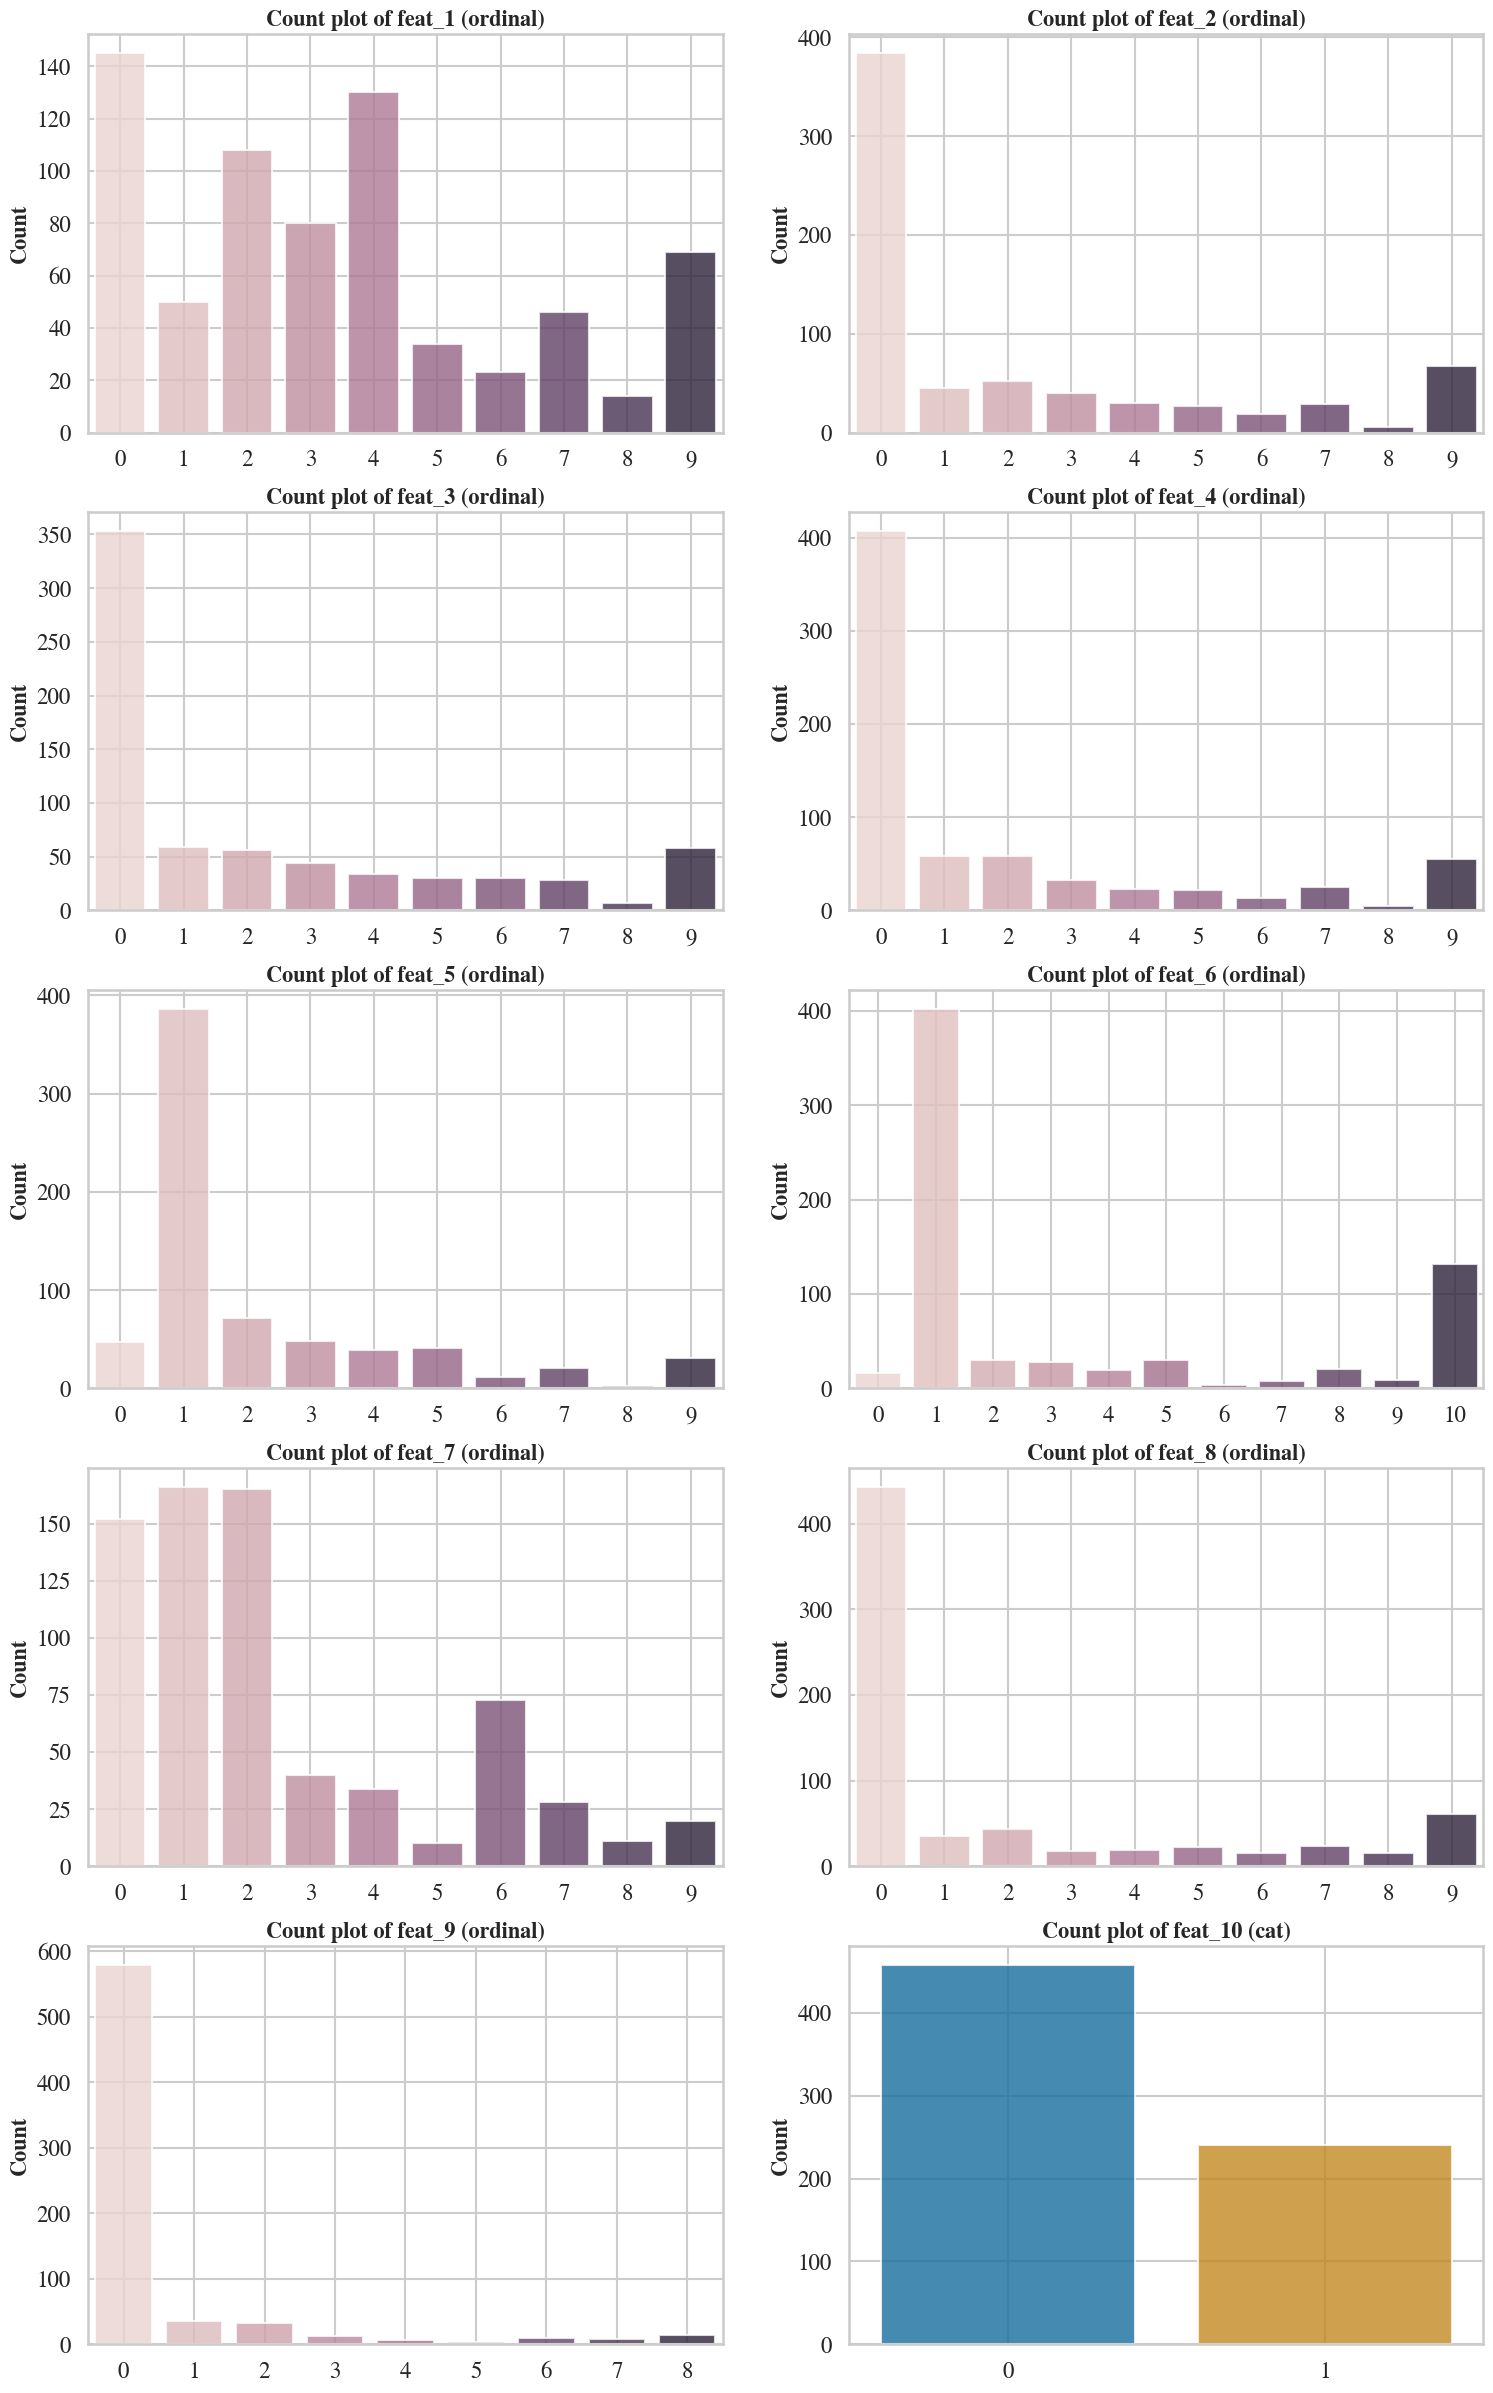

In [3]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)

# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(features_df, feat_types_dict)

### Experiment setting

In [4]:
# Train-test split
train_test_share = .8
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 1000
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

### Model loading

In [5]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 10
dim_latent_y = 5
dim_latent_s = 10
epochs = 2000
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

Clusters: 8
Epoch: [ 0]  time: 0.0471, ELBO_train: -20.31104088, KL_z: 1.11830556, KL_s: 0.03513646, reconstruction loss: -19.15759885
Clusters: 8
Epoch: [ 1]  time: 0.0619, ELBO_train: -20.14840889, KL_z: 0.99671417, KL_s: 0.03341246, reconstruction loss: -19.11828226
Clusters: 7
Epoch: [ 2]  time: 0.0759, ELBO_train: -20.06431198, KL_z: 0.89851701, KL_s: 0.03229356, reconstruction loss: -19.13350141
Clusters: 7
Epoch: [ 3]  time: 0.0884, ELBO_train: -19.94147301, KL_z: 0.78783435, KL_s: 0.03161836, reconstruction loss: -19.12202030
Clusters: 7
Epoch: [ 4]  time: 0.1011, ELBO_train: -19.84833717, KL_z: 0.73243266, KL_s: 0.03099322, reconstruction loss: -19.08491129
Clusters: 7
Epoch: [ 5]  time: 0.1146, ELBO_train: -19.78181267, KL_z: 0.65413725, KL_s: 0.03068280, reconstruction loss: -19.09699261
Clusters: 7
Epoch: [ 6]  time: 0.1287, ELBO_train: -19.71756935, KL_z: 0.61081952, KL_s: 0.03048038, reconstruction loss: -19.07626945
Clusters: 7
Epoch: [ 7]  time: 0.1418, ELBO_train: -19.

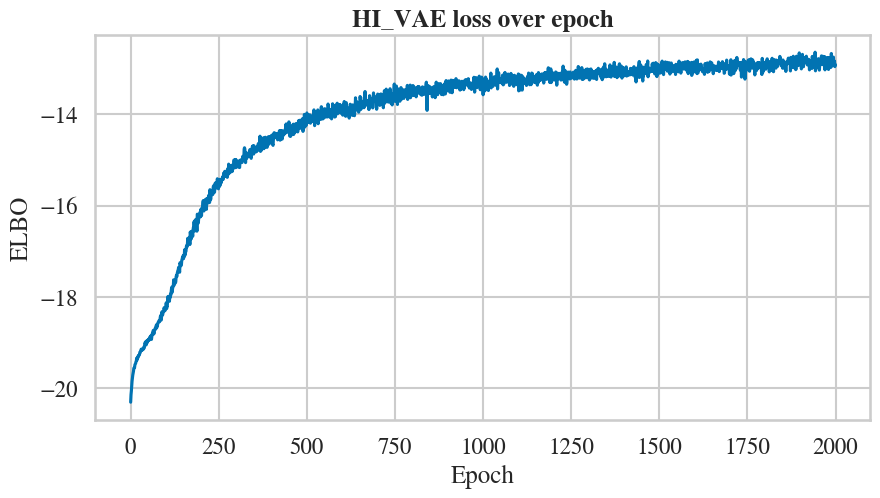

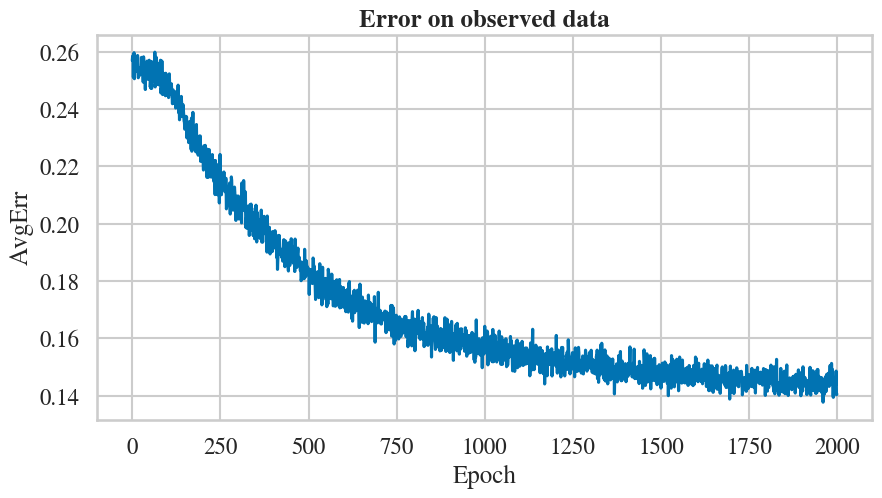

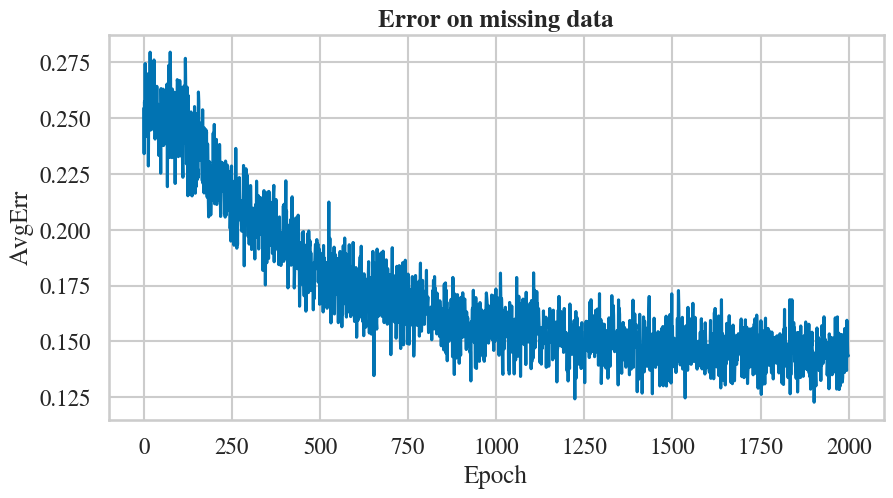

In [6]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []

for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = np.random.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))

    visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
                                xlabel = "Epoch", ylabel = "AvgErr")
visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
                                xlabel = "Epoch", ylabel = "AvgErr")

### Test model

In [7]:
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_size = n_test_samples

# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)

# Number of samples generated by one input data
n_generated_sample = 10

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_test):
        data_list, miss_list = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]

        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_test = statistic.samples_concatenation(samples_list)[-1]
    data_test_transformed = data_processing.discrete_variables_transformation(data_test, feat_types_dict)
    est_data_test_transformed = []
    for j in range(n_generated_sample):
        est_data_test_transformed.append(data_processing.discrete_variables_transformation(est_data_test[i], feat_types_dict).unsqueeze(0))
    
    est_data_test_transformed = torch.cat(est_data_test_transformed, dim=0)

### Visualize the generated samples

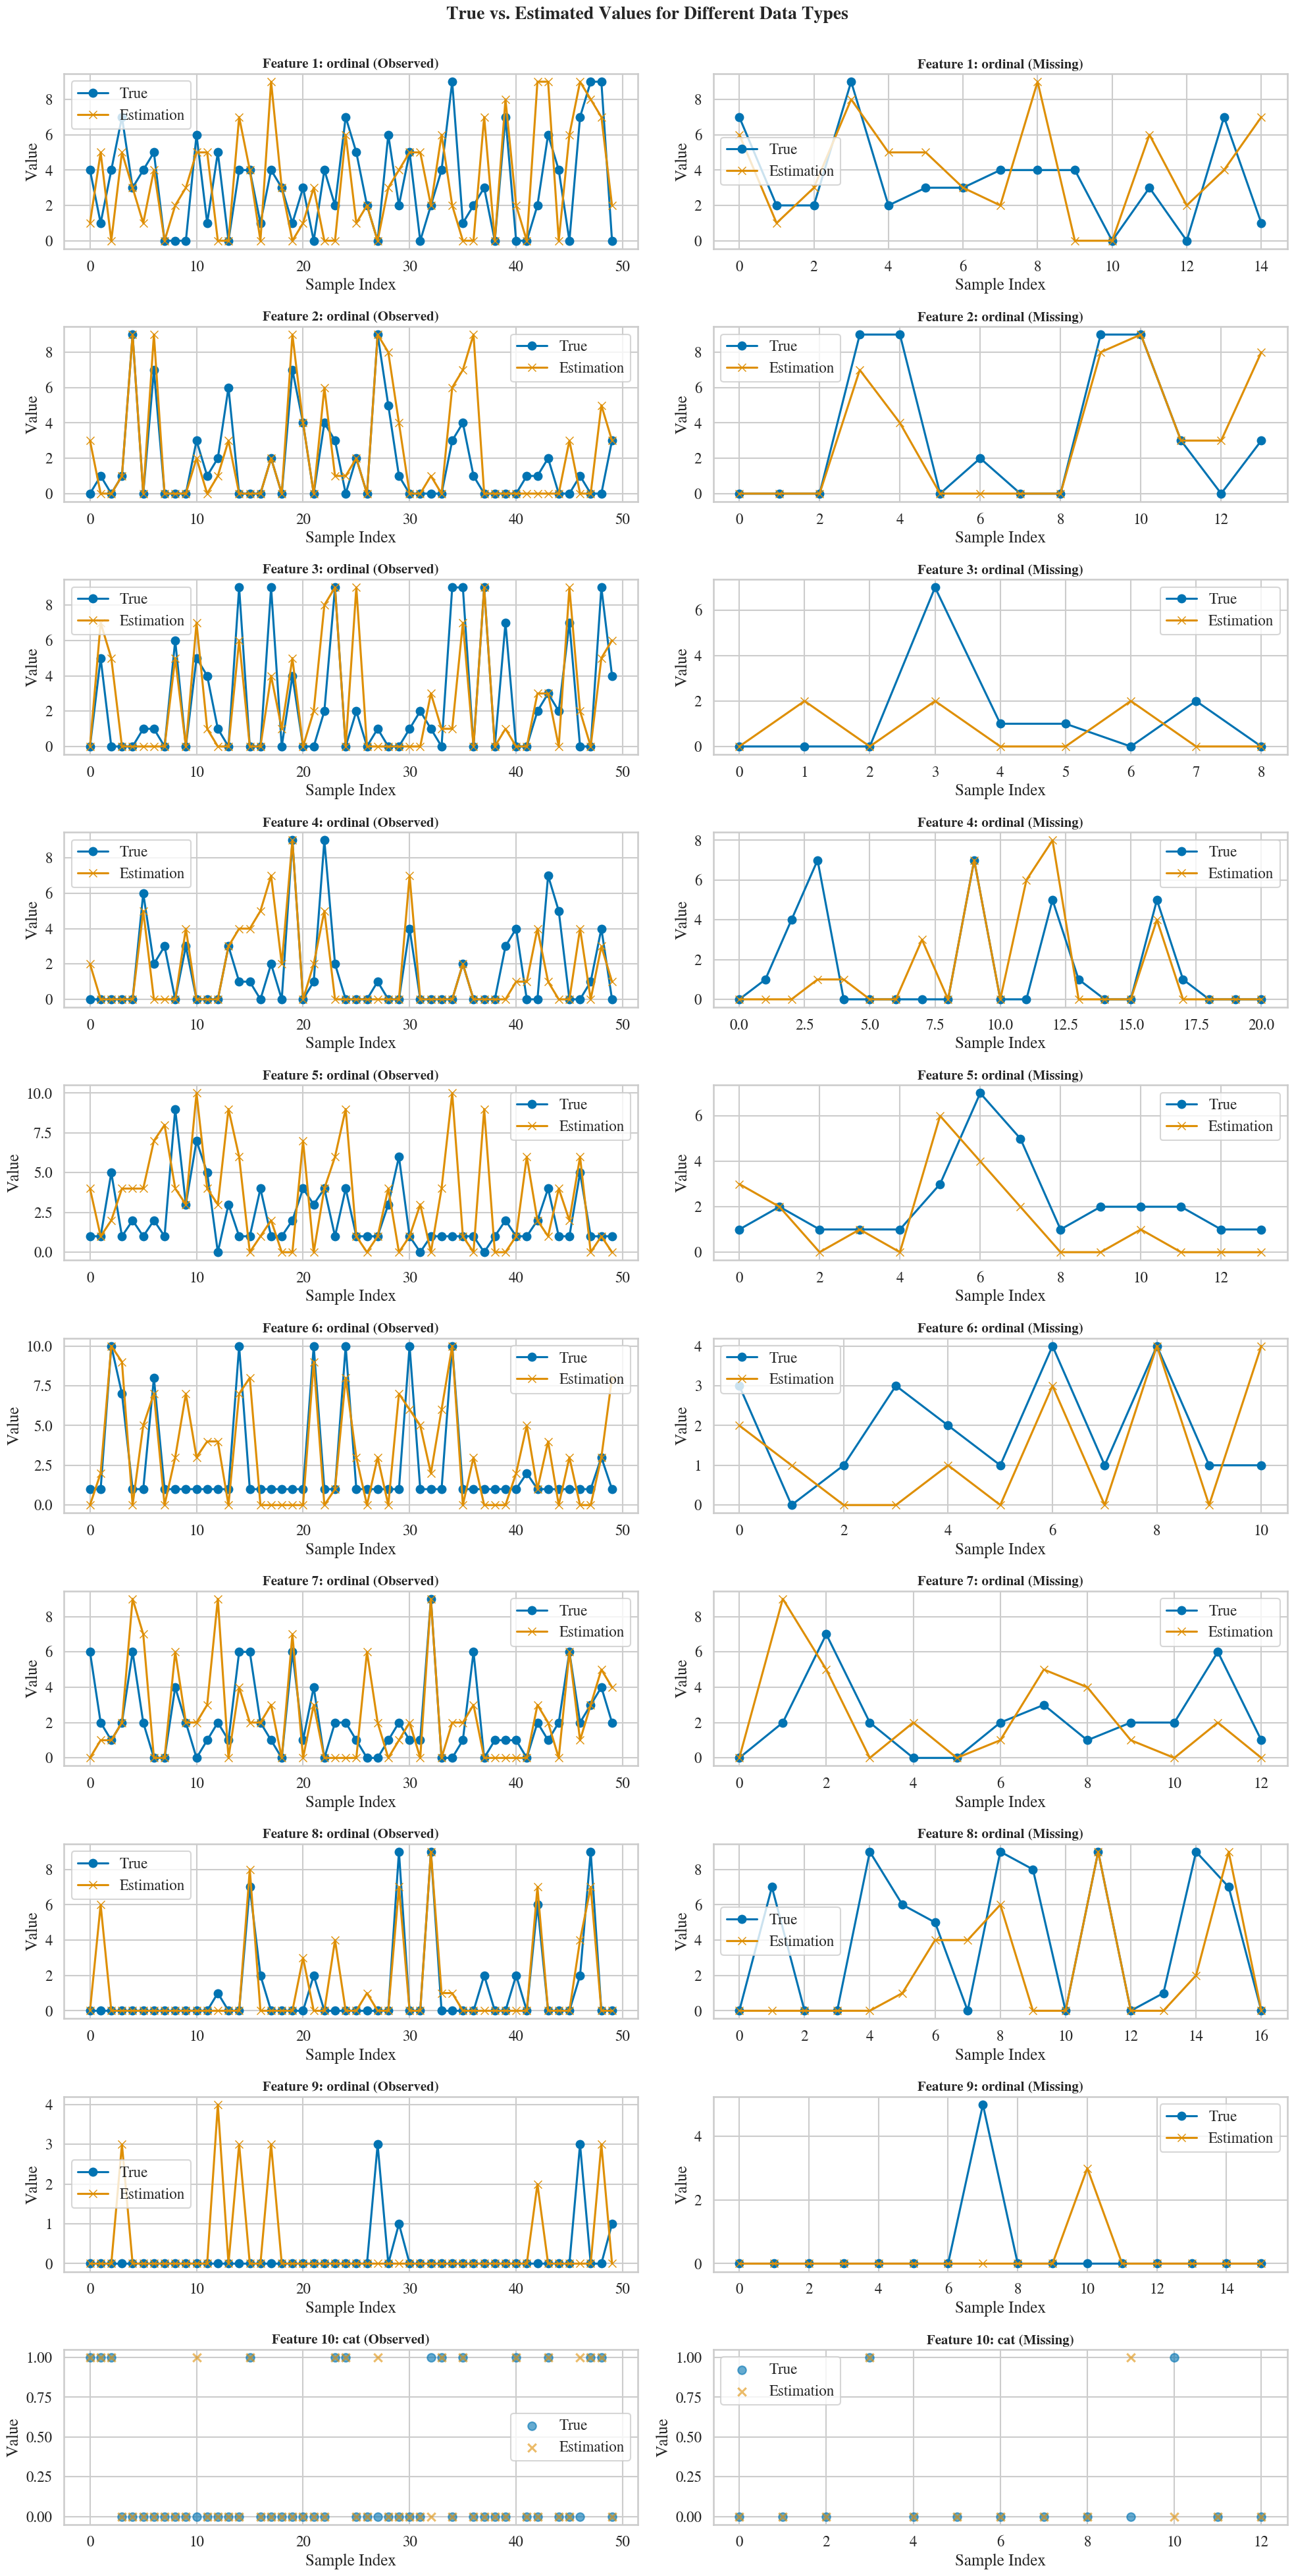

In [8]:
# Example Usage
torch.manual_seed(42)

true_values = data_test_transformed
# Take first generated sample
idx = 0
estimated_values = est_data_test_transformed[idx]

# Call plotting function
visualization.plot_true_vs_estimation(true_values, estimated_values, miss_mask_test, feat_types_dict, num_sel_samples=50)


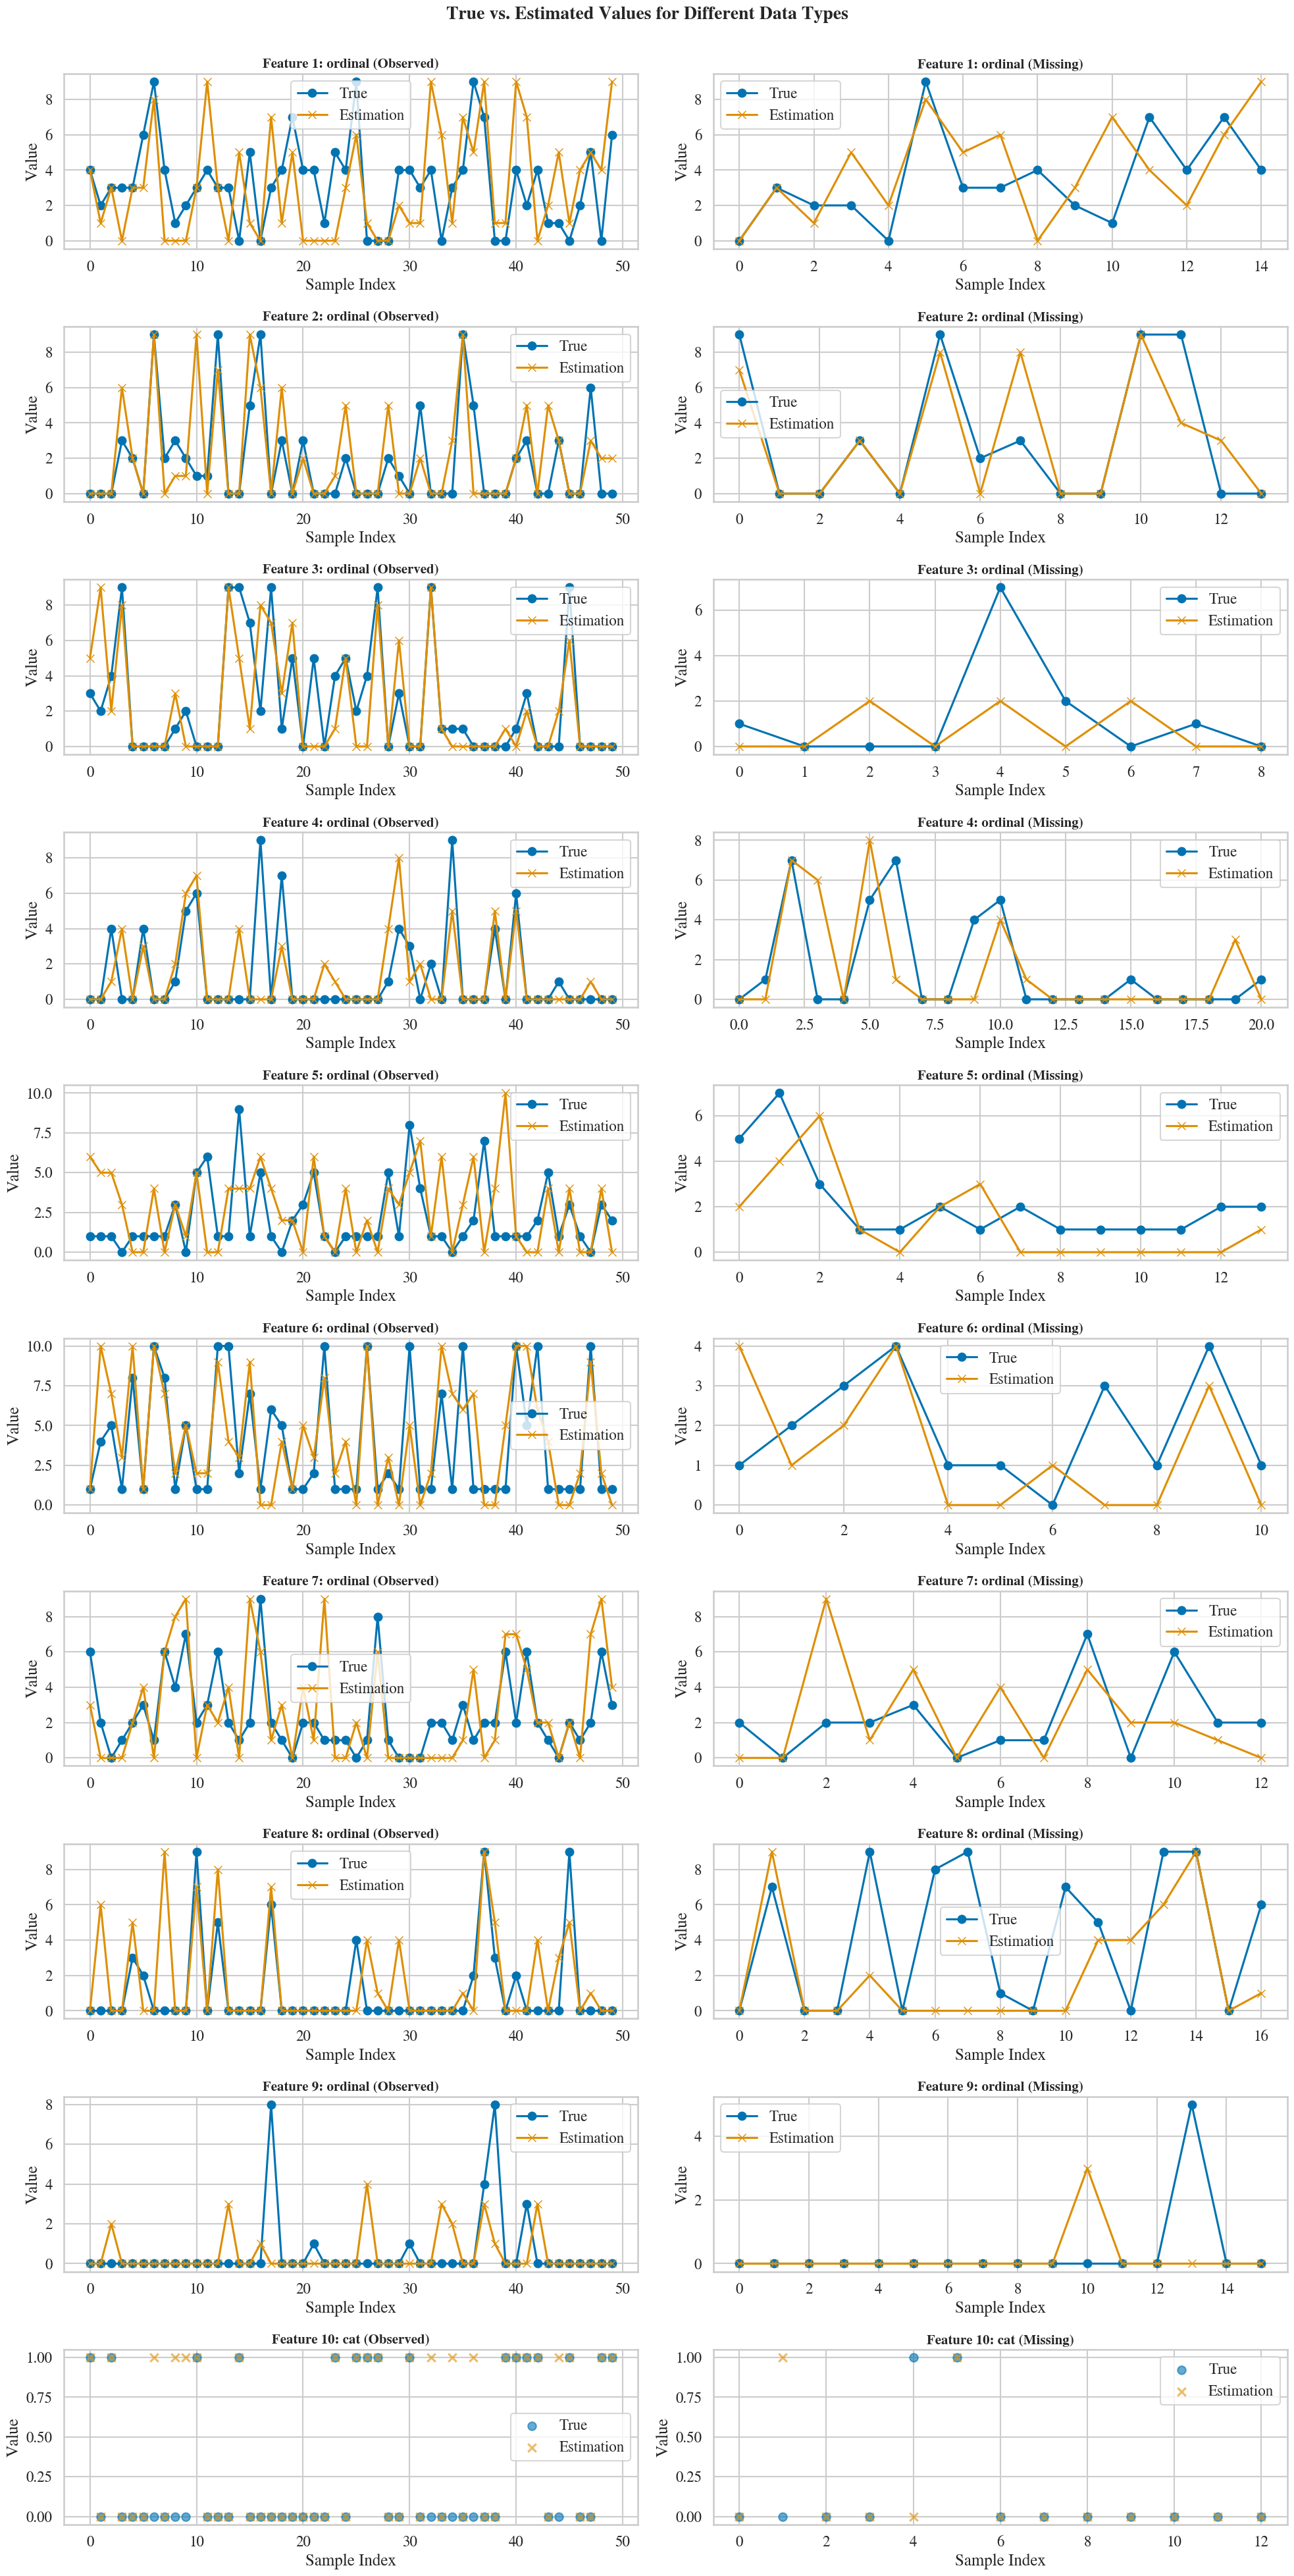

In [9]:
# Example Usage
torch.manual_seed(42)

true_values = data_test_transformed
# Take second generated sample
idx = 1
estimated_values = est_data_test_transformed[idx]

# Call plotting function
visualization.plot_true_vs_estimation(true_values, estimated_values, miss_mask_test, feat_types_dict, num_sel_samples=50)
